# Solar Spectrum Analysis Using a C920 Webcam

This matplotlib and scipy method seems to work well. I can easily read in a jpg. I think flatten=0 means to keep the RGB layers in the data matrix. flatten=1 makes a 2D matrix. Does it sum RGB?

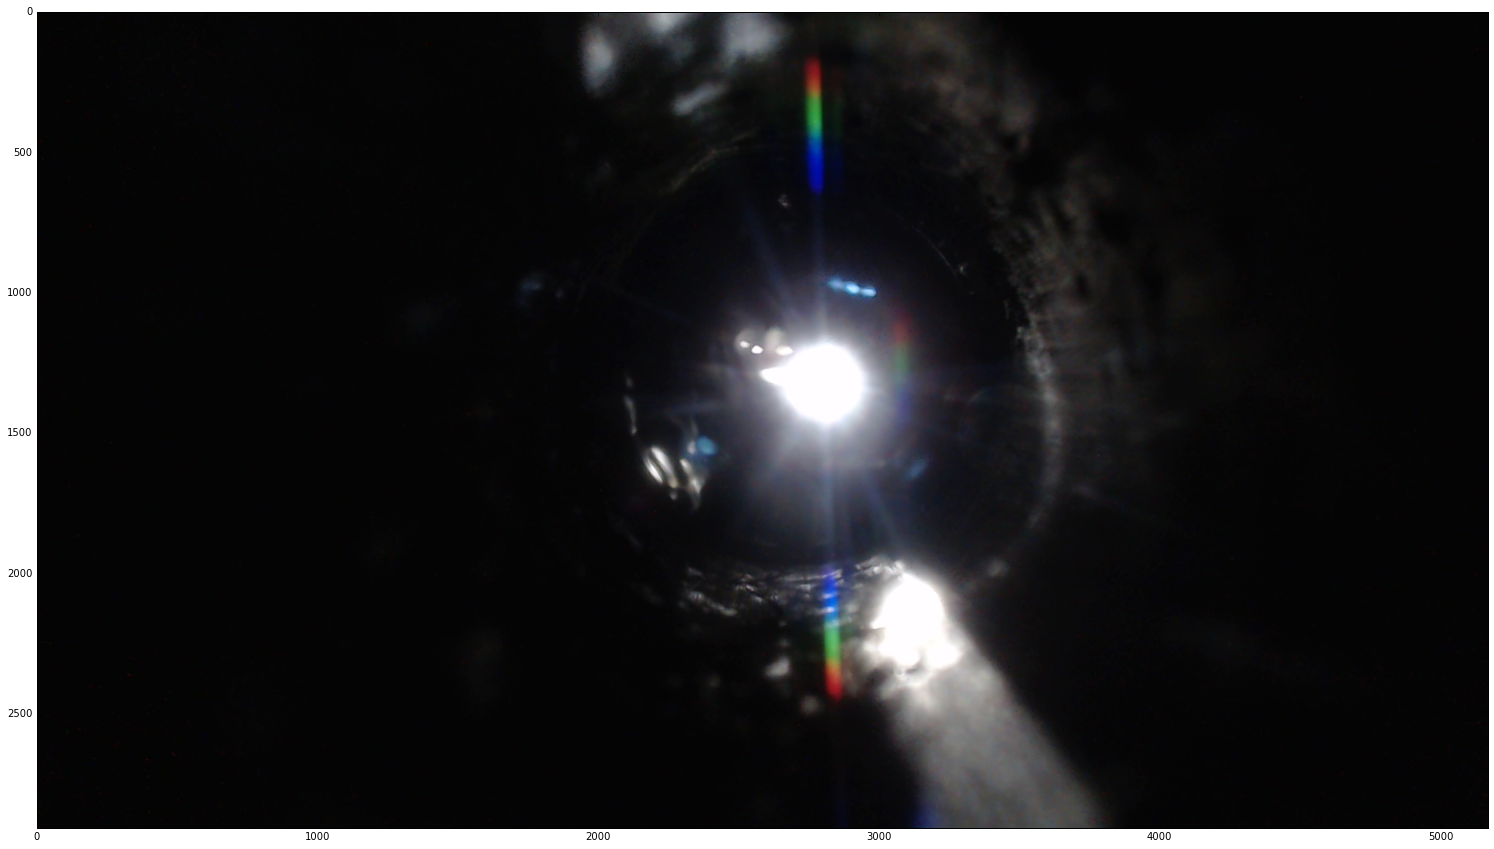

In [2]:
import matplotlib #import imshow, figure, zeros, plot
import scipy.ndimage
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from scipy.misc import imread
from scipy.ndimage.interpolation import rotate
from numpy import savetxt
 
a = imread("/home/nbuser/sun1.jpg",flatten=0) #5168x2907 pixels, 95 dpi
plt.figure(figsize=(26, 15))
plt.imshow(a)
plt.show()


Let's see if we can create a crop that zooms in on the spectrum at the bottom of the image. I'm using the pixels from the original image plot. I'm also adding a line to the plot and adjusting it until it runs along the spectrum. Once I have that, I should be able to collect RGB along the line and store them in an array.

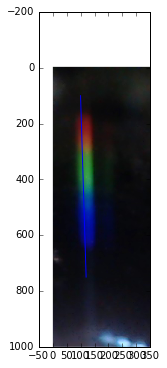

In [3]:
crop = a[0:1000,2650:3000]
plt.figure(figsize=(2, 20))
plt.imshow(crop)
linex = [100,120]
liney = [100,750]
plt.plot(linex,liney)
plt.show()

The image displays with linex on the horizontal and liney on the vertical as I've defined linex and liney. We need to know the line that is defined by the linex and liney arrays.
$$y = m x + b,$$

$$y = \frac{\Delta y}{\Delta x} x + b,$$

$$ y = \frac{liney[1]-liney[0]}{linex[1]-linex[0]} x + b.$$

$$m = \frac{750-100}{120-100} = 32.5$$

Since
$$y(100) = 32.5 \times 100 + b = 100$$

and

$$y(120) = 32.5 \times 120 + b = 750$$

$$b = -3150$$

Just to check our math, let's plot a line on the linex and liney points.

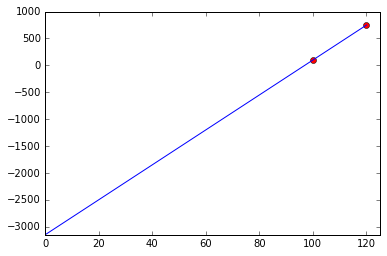

In [4]:
plt.plot(linex, liney, 'ro')
plt.plot([0,120], [-3150, 750])
plt.axis([0, 125, -3150, 1000])
plt.show()

That should be close enough. Now let's see if we can get the pixel intensities along the line. The jpg image is a 3D array of [[red, green, blue][x][y]]. Let's first separate red, green, blue into separate arrays. Alternatively, we could add them to make one layer, but it'll be nice to check that we've got everything right if we slice up the rgb image.

In [5]:
#Let's define the line parameters so we can use them later.
slope = 32.5
intercept = -3150

x rows = 1000
y columns = 350
z layers = 3


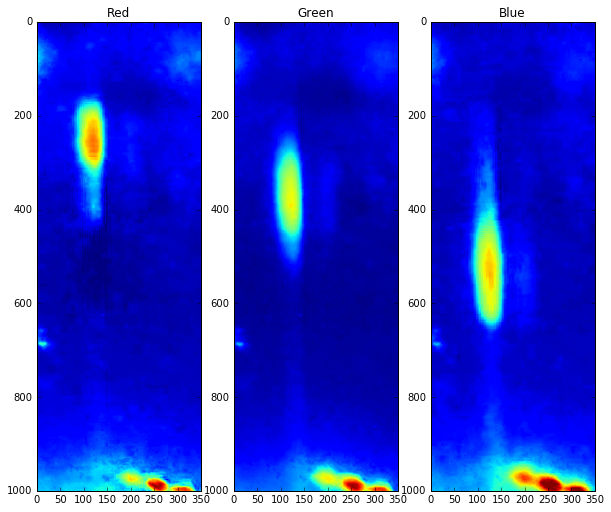

In [7]:
import numpy as np
arr = np.array(crop)
x, y, z = arr.shape
print("x rows =", x)
print("y columns =", y)
print("z layers =", z)

data = np.zeros((x*y, 5))
red = crop[:,:,0]
green = crop[:,:,1]
blue = crop[:,:,2]
#pixels = crop.load()
#for i in range(x):
#    for j in range(y):
#        red =  crop[i,j,0]
#        green = crop[i,j,1]
#        blue = crop[i,j,2]
#        data[i*col + j,:] = r,g,b,i,j

fig = plt.figure(figsize=(10, 20))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(red)
a.set_title('Red')
b=fig.add_subplot(1,3,2)
imgplot = plt.imshow(green)
b.set_title('Green')
c=fig.add_subplot(1,3,3)
imgplot = plt.imshow(blue)
c.set_title('Blue')
plt.show()

Cool! That worked. If you refer back to the original image, red was on top; green in the middle; and blue was on bottom. Now, let's get the values along the line we drew.

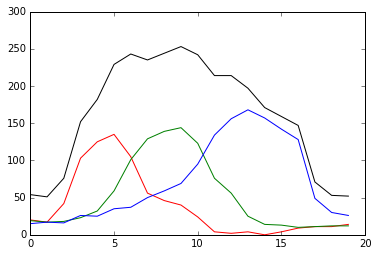

In [8]:
rarr = np.array(red)
garr = np.array(green)
barr = np.array(blue)
xmin = linex[0]
xmax = linex[1]
ymin = liney[0]
ymax = liney[1]
npts = xmax-xmin
profile_red = np.zeros((npts))
profile_green = np.zeros((npts))
profile_blue = np.zeros((npts))
for i in range(npts):
    pixelx = xmin + i
    pixely = round(slope * (xmin + i) + intercept) # We need to round because it's a pixel.
#    print (pixelx)
#    print (pixely)
    profile_red[i] = rarr[pixely,pixelx]
    profile_green[i] = garr[pixely,pixelx]
    profile_blue[i] = barr[pixely,pixelx]
profile_sum = profile_red + profile_green + profile_blue
plt.plot(profile_red, 'r', profile_green, 'g', profile_blue, 'b', profile_sum, 'k')
plt.show()

The data is in reverse wavelength order. Let's reverse it so it is intuitive.

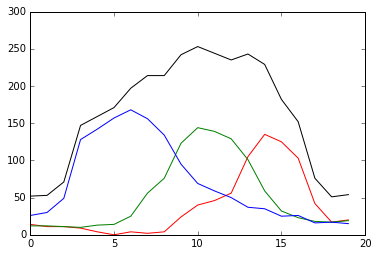

In [9]:
profile_red = profile_red[::-1]
profile_green = profile_green[::-1]
profile_blue = profile_blue[::-1]
profile_sum = profile_sum[::-1]
plt.plot(profile_red, 'r', profile_green, 'g', profile_blue, 'b', profile_sum, 'k')
plt.show()

Now, lets use scipy to do an interpolation. This will give a smoother profile with more data points, as many as we want, in fact. I found this tutorial https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array

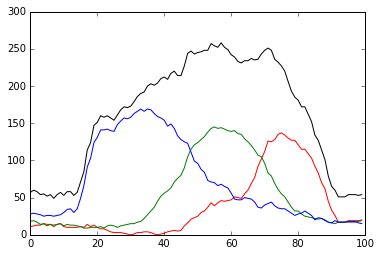

In [21]:
#-- Extract the line...
# Make a line with "num" points...
num = 100
x, y = np.linspace(xmin, xmax, num), np.linspace(ymin, ymax, num)

#z_red = np.arange(num,dtype='int64')
#z_green = np.arange(num,dtype='int64')
#z_blue = np.arange(num,dtype='int64')
#z_sum = np.arange(num,dtype='int64')

# Extract the values along the line, using cubic interpolation
z_red = scipy.ndimage.map_coordinates(rarr, np.vstack((y,x))) #The vstack creates a set of coordinates based upon the image's x and y we chose for the line
z_green = scipy.ndimage.map_coordinates(garr, np.vstack((y,x))) # The map_coordinates does an interpolation to try and best-guess the image value based upon surrounding pixels
z_blue = scipy.ndimage.map_coordinates(barr, np.vstack((y,x)))

#I can't seem to force the array to be long integer, and it's overflowing
#The quick solution is to divide each array first.
z_sum = 3*(z_red/3 + z_green/3 + z_blue/3)

#Let's reverse them
z_red = z_red[::-1]
z_green = z_green[::-1]
z_blue = z_blue[::-1]
z_sum = z_sum[::-1]

#Let's plot all of it
plt.plot(z_red, 'r', z_green, 'g', z_blue, 'b', z_sum, 'k')
plt.show()

Suppose we want to fit the blackbody spectrum to this summed spectrum. We first need to create an x-axis that is frequency or wavelength. I am going to use wavelength. We will need to use a known spectrum to calibrate. I found this response curve online. The blue line shows the built-in response of the camera. It is important to keep in mind that this response and the data collected (image of sun) are convolved mathematically. It is possible to deconvolve them if we have a careful measurement of the response. However, we will not do this. Looking at the response, we see that the camera's sensitive to about 400 nm to 650 nm. Our endpoints should be somewhere near this once we calibrate. The stuff in the IR above 1100 nm is resonance from the filter coating.

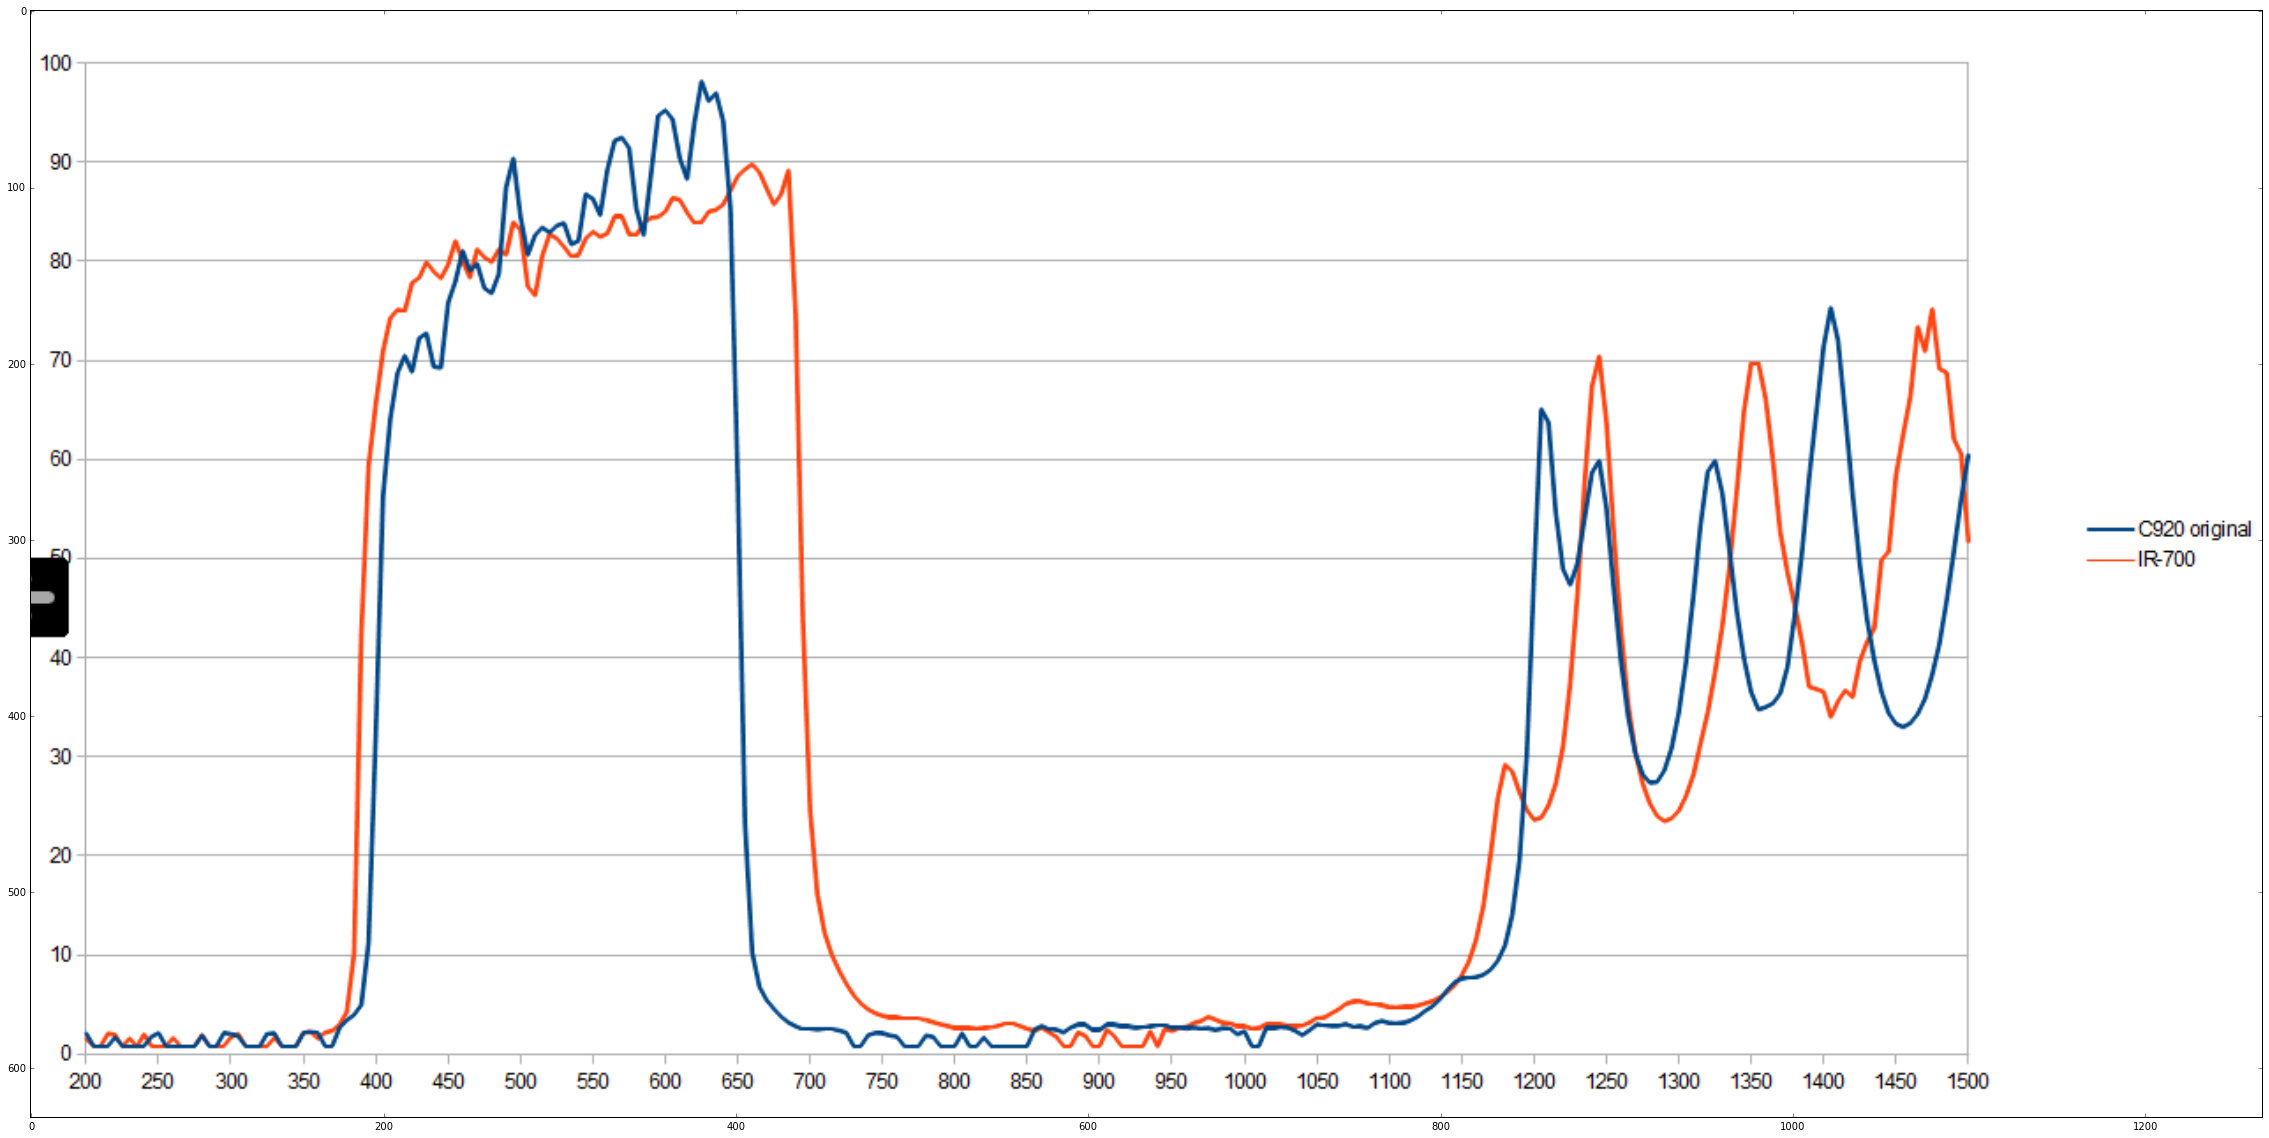

In [9]:
C920 = imread("C920-vs-IR700.png",flatten=0)
figC920 = plt.figure(figsize=(40, 60))
imgplot = plt.imshow(C920)
plt.show()

 To attempt to calibrate, I am going to use two laser pointers, red 633 nm and green 510 nm. 

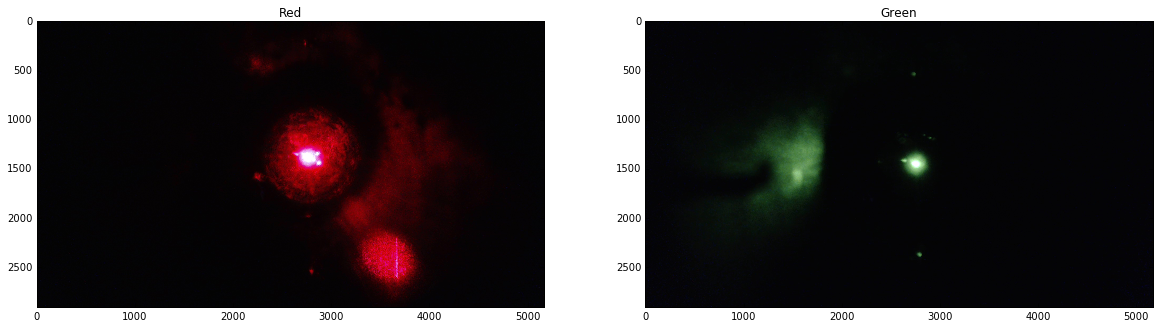

In [100]:
redlaser = imread("RedLaser2.jpg",flatten=0)
greenlaser = imread("GreenLaser.jpg",flatten=0)
fig = plt.figure(figsize=(20, 20))
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(redlaser)
a.set_title('Red')
b=fig.add_subplot(1,2,2)
imgplot = plt.imshow(greenlaser)
b.set_title('Green')
plt.show()

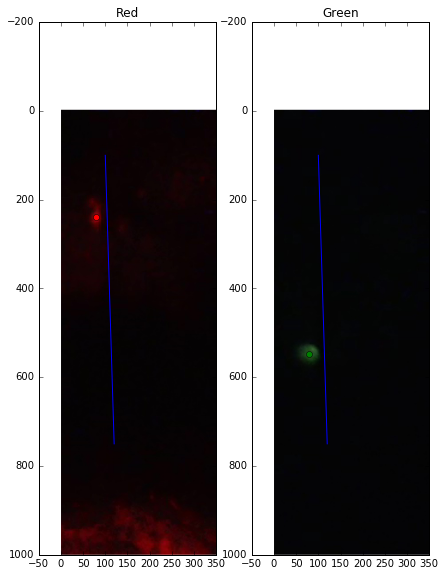

In [101]:
cropred = redlaser[0:1000,2650:3000]
cropgreen = greenlaser[0:1000,2650:3000]

fig = plt.figure(figsize=(7, 20))
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(cropred)
plt.plot(x,y)
plt.plot(80, 240,'ro') #Trying to find actual location of red spot
a.set_title('Red')
b=fig.add_subplot(1,2,2)
imgplot = plt.imshow(cropgreen)
plt.plot(x,y)
plt.plot(80, 547,'go') #Trying to find actual location of green spot
b.set_title('Green')
plt.show()

Unfortunately, the laser spots don't land on the line of the solar spectrum. Although the solar spectrum has a slight x-dependence, the laser spots do not. Let's assume the spectrum runs vertically in the image. Then, the wavelength is directly tied to the y-pixels of the image. When the wavelength is 633, the pixel is 240. When the wavelength is 510 nm, the pixel is 547. Assuming a linear translation, we can fit a line to these two data points.

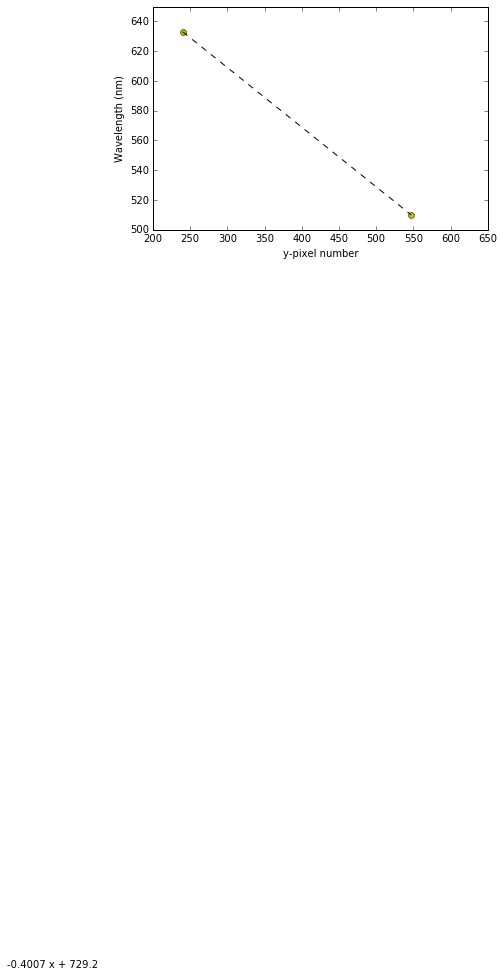

In [127]:
xs = [240, 547]
ys = [633, 510] #Two points is a perfect fit, but that's what we've got.
fit = np.polyfit(xs,ys,1)
fit_fn = np.poly1d(fit) 

# fit_fn is now a function which takes in x and returns an estimate for y
plt.text(4,4,fit_fn)
plt.plot(xs,ys, 'yo', xs, fit_fn(xs), '--k')
plt.xlim(200, 650)
plt.ylim(500, 650)
plt.xlabel('y-pixel number')
plt.ylabel('Wavelength (nm)')
plt.show()

Now we have a conversion $$\lambda = -0.4007 \rm{y-pixel} + 729.2.$$ Let's create a wavelength array from our y array and replot our spectrum.

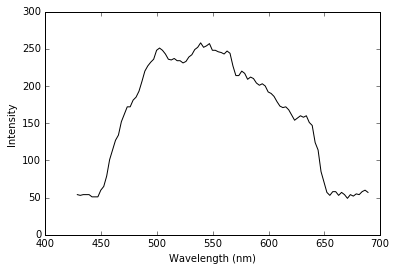

In [128]:
wavelength = -0.4007*y+729.2
wavelength = wavelength[::--1] # Don't forget to reverse it!
plt.plot(wavelength, z_sum, 'k')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

Once calibrated, you can fit the blackbody spectrum and identify Fraunhofer lines. You should do some research to understand what Fraunhofer lines are. Here is a plot of the solar spectrum with labeled Fraunhofer lines.

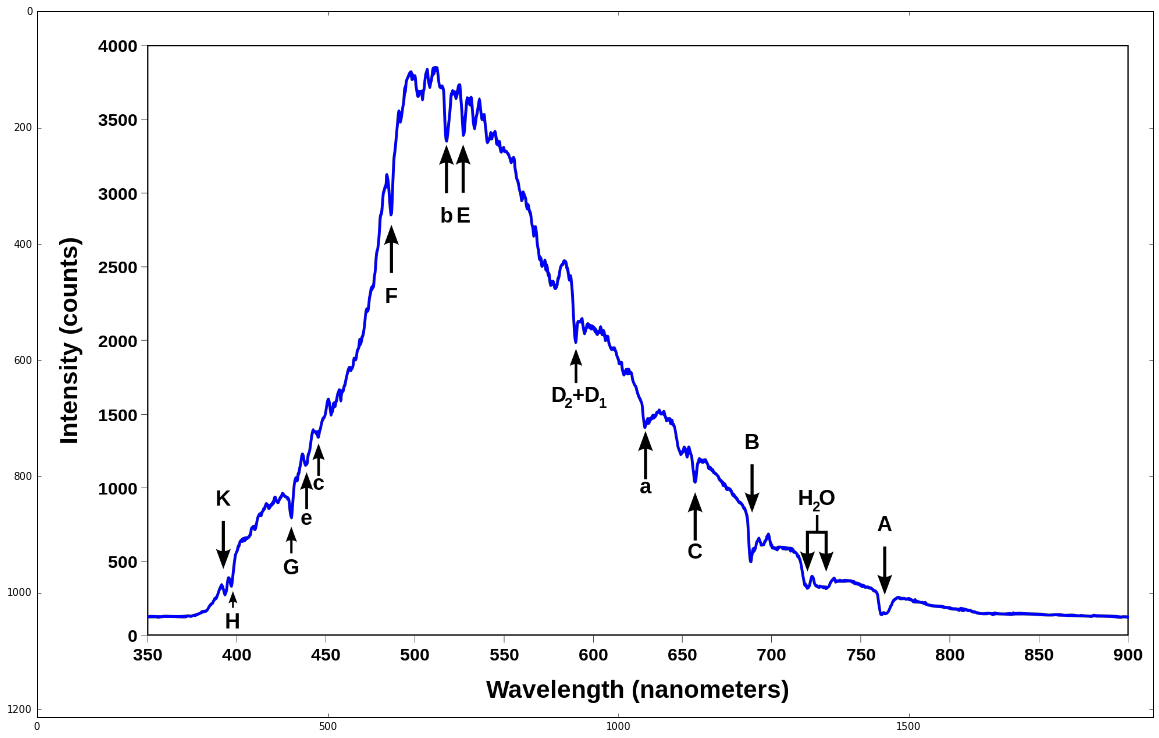

In [13]:
Fraun = imread("Fraunhofer.png",flatten=0)
figFraun = plt.figure(figsize=(20, 7))
imgplot = plt.imshow(Fraun)
plt.show()